<a href="https://colab.research.google.com/github/rpjayasekara/Fare-Classification-Problem/blob/master/fare_classification_refac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import all the necessary dependecies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from collections import Counter
from geopy.distance import geodesic
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [60]:
#read data
train = pd.read_csv('/content/drive/My Drive/train.csv') 
test = pd.read_csv('/content/drive/My Drive/test.csv')
com_data = [train, test] 
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [0]:
# Create a new feature fare time using the pick up and drop time
for data in com_data:
  data['pickup_time'] = pd.to_datetime(data['pickup_time'])
  data['drop_time'] = pd.to_datetime(data['drop_time'])
  data['fare_time'] = data['drop_time']-data['pickup_time']
  data['fare_time'] = data['fare_time'].dt.total_seconds()

In [0]:
# Create a new feature using pick up and drop up longitudes and latitudes
for data in com_data:
  geodesic((data['pick_lat'][0], data['pick_lon'][0]), (data['drop_lat'][0], data['drop_lon'][0])).meters
  for i, row in data.iterrows():
    data.at[i,'fare_distance'] = geodesic((data['pick_lat'][i], data['pick_lon'][i]), (data['drop_lat'][i], data['drop_lon'][i])).meters

In [0]:
for data in com_data:
  data['fare_distance'] = data['fare_distance']/1000

In [64]:
labels = {"label": {"correct": 1, "incorrect": 0}}
train = train.replace(labels)
com_data = [train, test] 
train.head(50)

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance
0,189123628,10.5,834.0,56.0,0.000000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1,840.0,5.072065
1,189125358,10.5,791.0,47.0,0.000000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1,780.0,3.151780
2,189125719,10.5,1087.0,80.0,0.000000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1,1080.0,6.302418
3,189127273,10.5,598.0,271.0,15.663800,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1,600.0,0.862654
4,189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1,1020.0,8.148521
5,189129552,10.5,3407.0,182.0,0.000000,112.0,2019-11-01 05:38:00,2019-11-01 06:35:00,7.13402,79.8969,6.91865,79.8649,1065.02,1,3420.0,24.078955
6,189132829,10.5,1246.0,487.0,0.000000,133.0,2019-11-01 06:29:00,2019-11-01 06:49:00,6.84371,79.9051,6.85069,79.8624,266.62,1,1200.0,4.782373
7,189135103,10.5,1333.0,295.0,17.198500,212.0,2019-11-01 06:50:00,2019-11-01 07:12:00,6.90760,79.9524,6.90634,79.9042,318.05,1,1320.0,5.328740
8,189139296,10.5,360.0,80.0,4.664000,3.0,2019-11-01 07:00:00,2019-11-01 07:06:00,7.26706,80.6064,7.27422,80.6124,100.32,1,360.0,1.032484
9,189138671,10.5,1539.0,588.0,33.986400,43.0,2019-11-01 07:02:00,2019-11-01 07:28:00,6.85137,79.9537,6.84779,79.9274,257.89,1,1560.0,2.933782


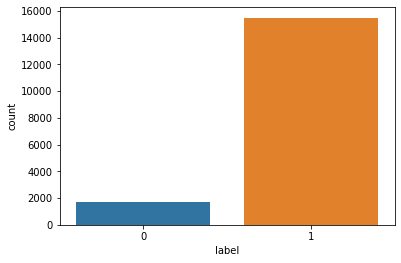

In [65]:
sns.countplot(train.label);

In [66]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   tripid                     17176 non-null  int64         
 1   additional_fare            16974 non-null  float64       
 2   duration                   16974 non-null  float64       
 3   meter_waiting              16974 non-null  float64       
 4   meter_waiting_fare         16974 non-null  float64       
 5   meter_waiting_till_pickup  16974 non-null  float64       
 6   pickup_time                17176 non-null  datetime64[ns]
 7   drop_time                  17176 non-null  datetime64[ns]
 8   pick_lat                   17176 non-null  float64       
 9   pick_lon                   17176 non-null  float64       
 10  drop_lat                   17176 non-null  float64       
 11  drop_lon                   17176 non-null  float64       
 12  fare

tripid                         0
additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         137
label                          0
fare_time                      0
fare_distance                  0
dtype: int64

In [67]:
train['additional_fare'].fillna(train['additional_fare'].dropna().median(), inplace=True)
train['duration'].fillna(train['duration'].dropna().mean(), inplace=True)
train['meter_waiting'].fillna(train['meter_waiting'].dropna().mean(), inplace=True)
train['meter_waiting_fare'].fillna(0, inplace=True)
train['meter_waiting_till_pickup'].fillna(train['meter_waiting_till_pickup'].dropna().mean(), inplace=True)
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance
0,189123628,10.5,834.000000,56.000000,0.0000,64.000000,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1,840.0,5.072065
1,189125358,10.5,791.000000,47.000000,0.0000,134.000000,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1,780.0,3.151780
2,189125719,10.5,1087.000000,80.000000,0.0000,61.000000,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1,1080.0,6.302418
3,189127273,10.5,598.000000,271.000000,15.6638,68.000000,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1,600.0,0.862654
4,189128020,10.5,1702.858077,629.074231,0.0000,112.466832,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1,1020.0,8.148521


In [68]:
for i, row in train.iterrows():
  if (np.isnan(train['fare'][i]) and train['label'][i]==0):
    train['fare'][i] = train['fare'].max()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
# Create a new feature using fare time and fare
for data in com_data:
  for i, row in data.iterrows():
    data.at[i,'fare_per_second'] = data['fare'][i]/data['fare_time'][i]
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance,fare_per_second
0,189123628,10.5,834.000000,56.000000,0.0000,64.000000,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1,840.0,5.072065,0.321810
1,189125358,10.5,791.000000,47.000000,0.0000,134.000000,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1,780.0,3.151780,0.253654
2,189125719,10.5,1087.000000,80.000000,0.0000,61.000000,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1,1080.0,6.302418,0.279296
3,189127273,10.5,598.000000,271.000000,15.6638,68.000000,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1,600.0,0.862654,0.137167
4,189128020,10.5,1702.858077,629.074231,0.0000,112.466832,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1,1020.0,8.148521,0.351363


In [70]:
# Create a new feature using fare distance and fare
for data in com_data:
  for i, row in data.iterrows():
    data.at[i,'fare_per_meter'] = data['fare'][i]/data['fare_distance'][i]
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance,fare_per_second,fare_per_meter
0,189123628,10.5,834.000000,56.000000,0.0000,64.000000,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1,840.0,5.072065,0.321810,53.295852
1,189125358,10.5,791.000000,47.000000,0.0000,134.000000,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1,780.0,3.151780,0.253654,62.774057
2,189125719,10.5,1087.000000,80.000000,0.0000,61.000000,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1,1080.0,6.302418,0.279296,47.860999
3,189127273,10.5,598.000000,271.000000,15.6638,68.000000,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1,600.0,0.862654,0.137167,95.403207
4,189128020,10.5,1702.858077,629.074231,0.0000,112.466832,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1,1020.0,8.148521,0.351363,43.982216


In [71]:
# Create a new feature using fare distance and fare
for data in com_data:
  for i, row in data.iterrows():
    data.at[i,'real_time_per_fare'] = (data['duration'][i]-data['meter_waiting_till_pickup'][i])/data['fare'][i]
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance,fare_per_second,fare_per_meter,real_time_per_fare
0,189123628,10.5,834.000000,56.000000,0.0000,64.000000,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1,840.0,5.072065,0.321810,53.295852,2.848476
1,189125358,10.5,791.000000,47.000000,0.0000,134.000000,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1,780.0,3.151780,0.253654,62.774057,3.320697
2,189125719,10.5,1087.000000,80.000000,0.0000,61.000000,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1,1080.0,6.302418,0.279296,47.860999,3.401406
3,189127273,10.5,598.000000,271.000000,15.6638,68.000000,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1,600.0,0.862654,0.137167,95.403207,6.439854
4,189128020,10.5,1702.858077,629.074231,0.0000,112.466832,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1,1020.0,8.148521,0.351363,43.982216,4.437599


In [72]:
for data in com_data:
  data['pickup_time_hour'] = data['pickup_time'].dt.hour
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance,fare_per_second,fare_per_meter,real_time_per_fare,pickup_time_hour
0,189123628,10.5,834.000000,56.000000,0.0000,64.000000,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1,840.0,5.072065,0.321810,53.295852,2.848476,0
1,189125358,10.5,791.000000,47.000000,0.0000,134.000000,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1,780.0,3.151780,0.253654,62.774057,3.320697,0
2,189125719,10.5,1087.000000,80.000000,0.0000,61.000000,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1,1080.0,6.302418,0.279296,47.860999,3.401406,1
3,189127273,10.5,598.000000,271.000000,15.6638,68.000000,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1,600.0,0.862654,0.137167,95.403207,6.439854,2
4,189128020,10.5,1702.858077,629.074231,0.0000,112.466832,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1,1020.0,8.148521,0.351363,43.982216,4.437599,3


In [73]:
for data in com_data:
  data['total_fare'] = data['meter_waiting_fare']+data['fare']+data['additional_fare']
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance,fare_per_second,fare_per_meter,real_time_per_fare,pickup_time_hour,total_fare
0,189123628,10.5,834.000000,56.000000,0.0000,64.000000,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1,840.0,5.072065,0.321810,53.295852,2.848476,0,280.8200
1,189125358,10.5,791.000000,47.000000,0.0000,134.000000,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1,780.0,3.151780,0.253654,62.774057,3.320697,0,208.3500
2,189125719,10.5,1087.000000,80.000000,0.0000,61.000000,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1,1080.0,6.302418,0.279296,47.860999,3.401406,1,312.1400
3,189127273,10.5,598.000000,271.000000,15.6638,68.000000,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1,600.0,0.862654,0.137167,95.403207,6.439854,2,108.4638
4,189128020,10.5,1702.858077,629.074231,0.0000,112.466832,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1,1020.0,8.148521,0.351363,43.982216,4.437599,3,368.8900


In [74]:
for data in com_data:
  data['fare_on_ride'] = (data['duration']-data['meter_waiting'])/data['fare']
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance,fare_per_second,fare_per_meter,real_time_per_fare,pickup_time_hour,total_fare,fare_on_ride
0,189123628,10.5,834.000000,56.000000,0.0000,64.000000,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1,840.0,5.072065,0.321810,53.295852,2.848476,0,280.8200,2.878070
1,189125358,10.5,791.000000,47.000000,0.0000,134.000000,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1,780.0,3.151780,0.253654,62.774057,3.320697,0,208.3500,3.760425
2,189125719,10.5,1087.000000,80.000000,0.0000,61.000000,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1,1080.0,6.302418,0.279296,47.860999,3.401406,1,312.1400,3.338417
3,189127273,10.5,598.000000,271.000000,15.6638,68.000000,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1,600.0,0.862654,0.137167,95.403207,6.439854,2,108.4638,3.973269
4,189128020,10.5,1702.858077,629.074231,0.0000,112.466832,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1,1020.0,8.148521,0.351363,43.982216,4.437599,3,368.8900,2.996132


In [75]:
for data in com_data:
  data['ride_fare_per_meter'] = (data['duration']-data['meter_waiting'])/data['fare_distance']
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance,fare_per_second,fare_per_meter,real_time_per_fare,pickup_time_hour,total_fare,fare_on_ride,ride_fare_per_meter
0,189123628,10.5,834.000000,56.000000,0.0000,64.000000,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1,840.0,5.072065,0.321810,53.295852,2.848476,0,280.8200,2.878070,153.389216
1,189125358,10.5,791.000000,47.000000,0.0000,134.000000,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1,780.0,3.151780,0.253654,62.774057,3.320697,0,208.3500,3.760425,236.057105
2,189125719,10.5,1087.000000,80.000000,0.0000,61.000000,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1,1080.0,6.302418,0.279296,47.860999,3.401406,1,312.1400,3.338417,159.779956
3,189127273,10.5,598.000000,271.000000,15.6638,68.000000,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1,600.0,0.862654,0.137167,95.403207,6.439854,2,108.4638,3.973269,379.062561
4,189128020,10.5,1702.858077,629.074231,0.0000,112.466832,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1,1020.0,8.148521,0.351363,43.982216,4.437599,3,368.8900,2.996132,131.776536


In [76]:
for data in com_data:
  data['waiting_rate'] = (data['meter_waiting'])/data['meter_waiting_fare']
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance,fare_per_second,fare_per_meter,real_time_per_fare,pickup_time_hour,total_fare,fare_on_ride,ride_fare_per_meter,waiting_rate
0,189123628,10.5,834.000000,56.000000,0.0000,64.000000,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1,840.0,5.072065,0.321810,53.295852,2.848476,0,280.8200,2.878070,153.389216,inf
1,189125358,10.5,791.000000,47.000000,0.0000,134.000000,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1,780.0,3.151780,0.253654,62.774057,3.320697,0,208.3500,3.760425,236.057105,inf
2,189125719,10.5,1087.000000,80.000000,0.0000,61.000000,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1,1080.0,6.302418,0.279296,47.860999,3.401406,1,312.1400,3.338417,159.779956,inf
3,189127273,10.5,598.000000,271.000000,15.6638,68.000000,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1,600.0,0.862654,0.137167,95.403207,6.439854,2,108.4638,3.973269,379.062561,17.301038
4,189128020,10.5,1702.858077,629.074231,0.0000,112.466832,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1,1020.0,8.148521,0.351363,43.982216,4.437599,3,368.8900,2.996132,131.776536,inf


In [77]:
train.isnull().sum()

tripid                         0
additional_fare                0
duration                       0
meter_waiting                  0
meter_waiting_fare             0
meter_waiting_till_pickup      0
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                           0
label                          0
fare_time                      0
fare_distance                  0
fare_per_second                0
fare_per_meter                 0
real_time_per_fare             0
pickup_time_hour               0
total_fare                     0
fare_on_ride                   2
ride_fare_per_meter            0
waiting_rate                 729
dtype: int64

In [0]:
train['additional_fare'].fillna(train['additional_fare'].dropna().median(), inplace=True)
train['duration'].fillna(train['duration'].dropna().mean(), inplace=True)
train['meter_waiting'].fillna(train['meter_waiting'].dropna().mean(), inplace=True)
train['meter_waiting_fare'].fillna(0, inplace=True)
train['meter_waiting_till_pickup'].fillna(train['meter_waiting_till_pickup'].dropna().mean(), inplace=True)
train['real_time_per_fare'].fillna(train['real_time_per_fare'].dropna().mean(), inplace=True)
train['total_fare'].fillna(train['total_fare'].dropna().mean(), inplace=True)
train['fare_on_ride'].fillna(train['fare_on_ride'].dropna().mean(), inplace=True)
train['ride_fare_per_meter'].fillna(train['fare_on_ride'].dropna().mean(), inplace=True)
train['waiting_rate'].fillna(train['waiting_rate'].dropna().mean(), inplace=True)

In [79]:
train.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,fare_time,fare_distance,fare_per_second,fare_per_meter,real_time_per_fare,pickup_time_hour,total_fare,fare_on_ride,ride_fare_per_meter,waiting_rate
count,1.717600e+04,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,17176.000000,1.717600e+04,1.717600e+04,1.717600e+04,17176.000000,17176.000000,1.717600e+04,1.717600e+04,1.717600e+04
mean,2.014549e+08,13.681786,1702.858077,629.074231,31.680648,112.466832,6.965499,79.998389,6.968587,79.997534,525.089492,0.902131,1713.929902,4.845562,inf,inf,NaN,13.817536,570.451926,inf,inf,inf
std,7.456830e+06,98.391906,8072.267835,8015.703284,462.751042,439.447558,0.210760,0.243384,0.378669,0.359648,2444.686331,0.297146,8101.459112,42.954576,NaN,NaN,NaN,4.824091,2593.222925,NaN,NaN,NaN
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-inf,0.000000,0.000000,-1.171901e+01,-2.347641e+05,1.628333e+01
25%,1.947619e+08,10.500000,552.000000,33.000000,0.000000,26.000000,6.865077,79.870400,6.865625,79.870100,125.960000,1.000000,540.000000,1.482193,1.730663e-01,4.823441e+01,3.029444e+00,10.000000,141.867500,3.039645e+00,1.814690e+02,1.727930e+01
50%,2.013582e+08,10.500000,1027.000000,128.000000,0.000000,74.000000,6.914105,79.898600,6.916160,79.899100,213.010000,1.000000,1020.000000,3.210817,2.200313e-01,5.923699e+01,4.082606e+00,14.000000,235.399600,3.737789e+00,2.288316e+02,inf
75%,2.083081e+08,10.500000,1786.000000,367.000000,13.987600,143.000000,7.043057,79.956600,7.047195,79.960225,371.740000,1.000000,1800.000000,6.143571,2.812926e-01,8.979436e+01,5.362376e+00,18.000000,404.413150,4.426531e+00,3.119825e+02,inf
max,2.138173e+08,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000,1.000000,453840.000000,5601.633929,inf,inf,inf,23.000000,53155.091400,inf,inf,inf


In [0]:
new_train = (pd.get_dummies(train[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 'fare_distance', 'ride_fare_per_meter', 'waiting_rate', 'fare_on_ride', 'pickup_time_hour', 'label']], dummy_na=True)).fillna(0)
new_test = (pd.get_dummies(test[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 'fare_distance', 'ride_fare_per_meter', 'waiting_rate', 'fare_on_ride', 'pickup_time_hour']], dummy_na=True)).fillna(0)

In [81]:
g = sns.heatmap(new_train[['duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 'fare_time', 'fare_distance', 'real_time_per_fare', 'fare_per_meter', 'fare_per_second', 'pickup_time_hour','pick_lat', 'pick_lon', 'label']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

KeyError: ignored

In [0]:
x_train = (pd.get_dummies(new_train[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare', 'fare_distance', 'ride_fare_per_meter', 'waiting_rate', 'fare_on_ride', 'pickup_time_hour']], dummy_na=True))
y_train = new_train['label']

In [0]:
y = y_train.values
x = x_train.values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 0)

In [0]:
random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, y_train)
acc_random_forest = round(random_forest.score(X_test, y_test) * 100, 2)
acc_random_forest

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: ignored

In [0]:
classes = ['Correct', 'Incorrect']
y_pred = random_forest.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     Correct       0.84      0.61      0.71       391
   Incorrect       0.96      0.99      0.98      3876

    accuracy                           0.95      4267
   macro avg       0.90      0.80      0.84      4267
weighted avg       0.95      0.95      0.95      4267



In [0]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
RFC = RandomForestClassifier()

kfold = StratifiedKFold(n_splits=10)
## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,1000],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 30.6min


KeyboardInterrupt: ignored

In [0]:
test_x = new_test.values
Y_pred = random_forest.predict(test_x)
submission = pd.DataFrame({
        "tripid": test["tripid"],
        "prediction": Y_pred
    })
submission.to_csv('/content/drive/My Drive/submission_12.csv', index=False)

In [0]:
params={
 "learning_rate"    : [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [0]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost
classifier=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=10,verbose=3)
random_search.fit(x_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ValueError: ignored

In [0]:
random_search.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.7,
 'learning_rate': 0.3,
 'max_depth': 12,
 'min_child_weight': 3}

In [0]:
import xgboost

model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.4,eval_metric='auc', importance_type='gain',
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=None, n_estimators=1000, n_jobs=6,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

# model = xgboost.XGBClassifier(n_estimators=200,base_score=0.1)

# model = xgboost.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
#               gamma=0.4, gpu_id=0, importance_type='gain',
#               interaction_constraints=None, learning_rate=0.01,
#               max_delta_step=0, max_depth=12, min_child_weight=7, missing=None,
#               monotone_constraints=None, n_estimators=1000, n_jobs=6, nthread=6,
#               num_parallel_tree=1, objective='binary:logistic', random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
#               subsample=0.8, tree_method='hist', validate_parameters=False,
#               verbosity=1)

In [0]:
from sklearn.model_selection import cross_val_score,KFold
score=cross_val_score(model, x_train, y_train, cv=10)
#print(score)
print("Mean cross validation score:%f"%score.mean())

kfold = KFold(n_splits=10)
kf_cv_scores = cross_val_score(model,X_train,y_train, cv=kfold)
print("K-fold CV average score: %f" % kf_cv_scores.mean())

Mean cross validation score:0.953481


NameError: ignored

In [84]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
train_X, val_X, train_y, val_y = train_test_split(x_train, y_train, random_state=1)
eval_set = [(train_X, train_y), (val_X, val_y)]
eval_metric = ['error','auc']
model.fit(train_X, train_y, eval_set=eval_set, eval_metric=eval_metric, verbose=True)


[0]	validation_0-error:0.043937	validation_0-auc:0.911683	validation_1-error:0.052166	validation_1-auc:0.877643
[1]	validation_0-error:0.043472	validation_0-auc:0.91243	validation_1-error:0.049604	validation_1-auc:0.878462
[2]	validation_0-error:0.042773	validation_0-auc:0.913785	validation_1-error:0.050769	validation_1-auc:0.880489
[3]	validation_0-error:0.043316	validation_0-auc:0.914863	validation_1-error:0.050769	validation_1-auc:0.880209
[4]	validation_0-error:0.043161	validation_0-auc:0.915133	validation_1-error:0.049837	validation_1-auc:0.880801
[5]	validation_0-error:0.042462	validation_0-auc:0.925054	validation_1-error:0.048207	validation_1-auc:0.89471
[6]	validation_0-error:0.04254	validation_0-auc:0.925075	validation_1-error:0.050303	validation_1-auc:0.894874
[7]	validation_0-error:0.043083	validation_0-auc:0.927712	validation_1-error:0.05007	validation_1-auc:0.897238
[8]	validation_0-error:0.042928	validation_0-auc:0.928217	validation_1-error:0.050303	validation_1-auc:0.897

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.4, learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=None, n_estimators=1000, n_jobs=6,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [85]:
from sklearn.metrics import f1_score

prediction = model.predict(val_X)

f1_score(val_y, prediction, average='macro')

0.8572796249692014

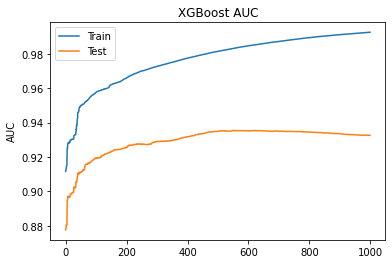

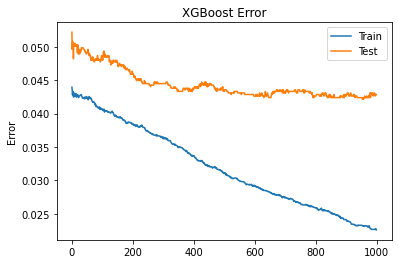

Model Performance
Accuracy:0.977410
Mean Squared Error : 0.0226
Root MSE : 0.1503


In [86]:
from matplotlib import pyplot

results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')
pyplot.show()

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Error')
pyplot.title('XGBoost Error')
pyplot.show()

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mse = mean_squared_error(test_labels, predictions)
    rmse = np.sqrt(mse)
    accuracy = accuracy_score(test_labels, predictions)
    print('Model Performance')
    print('Accuracy:%f'%accuracy)
    print('Mean Squared Error : %.4f' % mse)
    print('Root MSE : %.4f' % rmse)
    
evaluate(model, train_X, train_y)


In [0]:
classes = ['Correct', 'Incorrect']
y_pred = model.predict(val_X)
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(val_X, val_y, target_names=classes))

ValueError: ignored

In [56]:
print(model.feature_importances_)
train_X.head()

[0.07043006 0.05865146 0.05389972 0.05291541 0.05303293 0.13727549
 0.05192662 0.08117341 0.05568838 0.34166947 0.0433371 ]


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,fare_distance,ride_fare_per_meter,waiting_rate,fare_on_ride,pickup_time_hour
1140,10.5,378.0,91.0,5.305300,24.0,118.58,1167.400846,0.245845,17.152659,2.420307,9
1907,10.5,677.0,183.0,10.616145,52.0,141.74,1658.826862,0.297801,17.237896,3.485255,9
17169,10.5,2747.0,230.0,13.294000,287.0,821.29,3381.000346,0.744454,17.301038,3.064691,21
12054,10.5,629.0,34.0,1.982200,224.0,128.15,1960.256819,0.303532,17.152659,4.642996,8
11329,10.5,1925.0,240.0,0.000000,119.0,408.16,8508.146099,0.198045,inf,4.128283,20


In [0]:
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.4, learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=None, n_estimators=1000, n_jobs=6,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [0]:
Y_pred = model.predict(new_test)
submission = pd.DataFrame({
        "tripid": test["tripid"],
        "prediction": Y_pred
    })
submission.to_csv('/content/drive/My Drive/submission_22.csv', index=False)

In [0]:
# Train a Neural network 
import torch
from torch import nn, optim
import torch.nn.functional as F
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED)
X_train

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,fare_time,fare_distance
11271,0.047511,0.219321,0.073437,0.068318,0.014015,0.434670,0.219144,0.342746
8986,0.047511,0.046396,0.000643,0.000672,0.119131,0.113816,0.045340,0.120123
15881,0.047511,0.034074,0.005359,0.005597,0.230554,0.100430,0.035264,0.064755
12384,0.047511,0.054484,0.008874,0.005593,0.400841,0.115995,0.052897,0.077442
12207,0.047511,0.038600,0.004973,0.005149,0.050456,0.089250,0.037783,0.084058
...,...,...,...,...,...,...,...,...
11368,0.047511,0.060352,0.009089,0.000000,0.039944,0.158306,0.060453,0.170672
12051,0.047511,0.061945,0.002229,0.000000,0.368605,0.157584,0.060453,0.158789
5438,0.047511,0.040402,0.008274,0.000000,0.019622,0.208831,0.040302,0.072141
866,0.047511,0.048910,0.015862,0.016450,0.086896,0.112037,0.050378,0.050163


In [0]:
# Convert to tensors
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([13654, 8]) torch.Size([13654])
torch.Size([3414, 8]) torch.Size([3414])


In [0]:
# Define the Neural network
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 16)
    self.fc2 = nn.Linear(16, 32)
    self.fc3 = nn.Linear(32, 5)
    self.fc4 = nn.Linear(5, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return torch.sigmoid(self.fc4(x))

net = Net(X_train.shape[1]) 


In [0]:
# Lostt function
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Move the tensors if GPU available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)
criterion = criterion.to(device)

In [0]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)


In [0]:
for epoch in range(100):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)
      test_loss = criterion(y_test_pred, y_test)
      test_acc = calculate_accuracy(y_test, y_test_pred)
      print( f'''epoch {epoch}
            Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
            ''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
            Train set - loss: 0.718, accuracy: 0.093
            Test  set - loss: 0.718, accuracy: 0.098
            


In [0]:
classes = ['Correct', 'Incorrect']
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
y_pred

tensor([True, True, True,  ..., True, True, True])

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     Correct       0.00      0.00      0.00       333
   Incorrect       0.90      1.00      0.95      3081

    accuracy                           0.90      3414
   macro avg       0.45      0.50      0.47      3414
weighted avg       0.81      0.90      0.86      3414



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


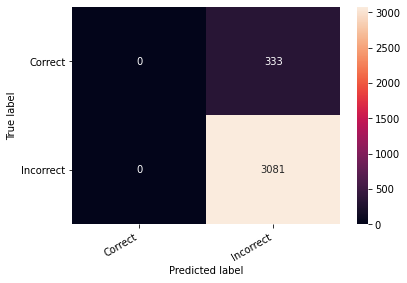

In [0]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [0]:
new_test

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,fare_time,fare_distance
0,10.5,924,42,2.44860,148,289.27,900.0,6670.189338
1,10.5,4249,20,0.00000,91,1912.70,4260.0,41351.053381
2,10.5,1552,255,2.65880,23,394.00,1560.0,5920.043673
3,10.5,462,16,0.00000,198,154.32,480.0,3283.812573
4,10.5,814,392,12.36920,69,147.47,840.0,2588.982212
...,...,...,...,...,...,...,...,...
8571,10.5,1723,429,24.83332,3,388.48,1680.0,3938.379720
8572,10.5,1378,80,0.00000,125,379.85,1380.0,7525.492844
8573,10.5,418,56,3.28440,93,112.79,420.0,2046.035595
8574,10.5,1604,548,31.67440,17,248.46,1620.0,3898.144196


In [0]:
test_x = torch.from_numpy(new_test.to_numpy()).float()
test_x = test_x.to(device)
test_y_pred = net(test_x)
test_y_pred = test_y_pred.ge(.5).view(-1).cpu()
test_y_pred[:1000]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [0]:
test_y_pred = test_y_pred.detach().numpy()
test_y_pred = test_y_pred.reshape(-1)

In [0]:
for i in test_y_pred:
  if i==False:
    print (i)

In [0]:
submission = pd.DataFrame({
        "tripid": test["tripid"],
        "prediction": test_y_pred
    })
submission.to_csv('/content/drive/My Drive/submission_8.csv', index=False)